<h1>Use siamese GNN to predict the similarity of two source codes</h1>

<h3>Import dependencies</h3>

In [252]:
from tree_sitter import Language, Parser
import tree_sitter_java as ts_java
import os
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F, torch.nn as nn
from torch_geometric.data import Batch
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np
import random

<h2>Data preparation</h2>

<h3>Define constants</h3>

In [253]:
java_directory1 = './datasets/conplag_preprocessed'
java_directory2 = './datasets/ir_plag_preprocessed'
java_LANGUAGE = Language(ts_java.language())
parser = Parser(java_LANGUAGE)
csv_paths = ['./labels/conplag-labels.csv', './labels/ir_plag_labels.csv']

In [254]:
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    return df

<h3>Get AST</h3>

In [255]:
def parse_java_file(filepath):
    with open(filepath, 'r', encoding='utf8') as file:
        code = file.read()

    tree = parser.parse(bytes(code, "utf8"))
    root_node = tree.root_node

    nodes = []
    edges = []

    def traverse(node, parent_idx=None):
        idx = len(nodes)
        nodes.append(node.type)
        
        if parent_idx is not None:
            edges.append((parent_idx, idx))
        
        for child in node.children:
            traverse(child, idx)

    traverse(root_node)
    return nodes, edges

<h3>Build data for GNN</h3>

In [256]:
def build_global_vocab(java_directories, file_lists):
    all_node_types = set()

    for java_directory, file_list in zip(java_directories, file_lists):
        for file_name in file_list:
            file_path = os.path.join(java_directory, file_name)
            nodes, _ = parse_java_file(file_path)
            all_node_types.update(nodes)

    node_type_to_idx = {typ: idx for idx, typ in enumerate(sorted(all_node_types))}
    return node_type_to_idx

def create_node_features(nodes, node_type_to_idx):
    node_features = [node_type_to_idx[typ] for typ in nodes]
    return node_features

def create_graph_data(nodes, edges, node_features, embedding_layer):
    x = embedding_layer(torch.tensor(node_features))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    data = Data(x=x, edge_index=edge_index)
    return data

In [257]:
class NodeEmbeddingLayer(nn.Module):
    def __init__(self, num_node_types, embedding_dim):
        super(NodeEmbeddingLayer, self).__init__()
        self.embeddings = nn.Embedding(num_node_types, embedding_dim)

    def forward(self, node_indices):
        return self.embeddings(node_indices)
    
embedding_dim = 16

In [258]:
def prepare_data_for_pairs(pairs_df, java_directory, node_type_to_idx, embedding_layer):
    data_pairs = []
    for idx, row in pairs_df.iterrows():
        file1, file2, label = row['id1'], row['id2'], row['plagio']

        file1_path = os.path.join(java_directory, file1)
        file2_path = os.path.join(java_directory, file2)

        nodes1, edges1 = parse_java_file(file1_path)
        nodes2, edges2 = parse_java_file(file2_path)

        node_features1 = create_node_features(nodes1, node_type_to_idx)
        node_features2 = create_node_features(nodes2, node_type_to_idx)

        data1 = create_graph_data(nodes1, edges1, node_features1, embedding_layer)
        data2 = create_graph_data(nodes2, edges2, node_features2, embedding_layer)

        data_pairs.append((data1, data2, label))
        
    return data_pairs

In [269]:
pairs_df1 = load_csv(csv_paths[0])
pairs_df2 = load_csv(csv_paths[1])

file_list1 = list(set(pairs_df1['id1'].tolist() + pairs_df1['id2'].tolist()))
file_list2 = list(set(pairs_df2['id1'].tolist() + pairs_df2['id2'].tolist()))

java_directories = [java_directory1, java_directory2]
file_lists = [file_list1, file_list2]

node_type_to_idx = build_global_vocab(java_directories, file_lists)
embedding_layer = NodeEmbeddingLayer(len(node_type_to_idx), embedding_dim)

data_pairs2 = prepare_data_for_pairs(pairs_df1, java_directory1, node_type_to_idx, embedding_layer)
val_pairs = data_pairs2[:int(len(data_pairs2) * 0.1)]
data_pairs1 = prepare_data_for_pairs(pairs_df2, java_directory2, node_type_to_idx, embedding_layer)
test_pairs = data_pairs1[:int(len(data_pairs1) * 0.2)]

data_pairs1 = [pair for pair in data_pairs1 if pair not in val_pairs]
data_pairs2 = [pair for pair in data_pairs2 if pair not in test_pairs]

all_data_pairs = data_pairs2

print("Data preparation complete.")
print(f"Number of pairs in dataset 1: {len(data_pairs1)}")
print(f"Number of pairs in dataset 2: {len(data_pairs2)}")
print(f"Number of pairs in validation set: {len(val_pairs)}")
print(f"Number of pairs in test set: {len(test_pairs)}")
data1, data2, label1 = data_pairs1[0]
data3, data4, label2 = data_pairs2[0]
print(f"Dataset 1 - First pair:")
print(f"  Graph 1: {data1.num_nodes} nodes, {data1.num_edges} edges")
print(f"  Graph 2: {data2.num_nodes} nodes, {data2.num_edges} edges")
print(f"  Label: {label1}")
print(f"Dataset 2 - First pair:")
print(f"  Graph 1: {data3.num_nodes} nodes, {data3.num_edges} edges")
print(f"  Graph 2: {data4.num_nodes} nodes, {data4.num_edges} edges")
print(f"  Label: {label2}")

Data preparation complete.
Number of pairs in dataset 1: 460
Number of pairs in dataset 2: 911
Number of pairs in validation set: 91
Number of pairs in test set: 92
Dataset 1 - First pair:
  Graph 1: 108 nodes, 107 edges
  Graph 2: 109 nodes, 108 edges
  Label: 1
Dataset 2 - First pair:
  Graph 1: 919 nodes, 918 edges
  Graph 2: 1246 nodes, 1245 edges
  Label: 0


<h2>Model</h2>

<h3>Build GNN siamese architecture</h3>

In [260]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return x

class SiameseNetwork(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SiameseNetwork, self).__init__()
        self.encoder = GNNEncoder(in_channels, hidden_channels, out_channels)

    def forward(self, data1, data2):
        h1 = self.encoder(data1.x, data1.edge_index, data1.batch)
        h2 = self.encoder(data2.x, data2.edge_index, data2.batch)
        return h1, h2

def contrastive_loss(h1, h2, label, margin=1.0):
    distance = F.pairwise_distance(h1, h2)
    loss = (label * torch.pow(distance, 2) + 
           (1 - label) * torch.pow(F.relu(margin - distance), 2))
    return loss.mean()

def collate_fn(pairs, device):
    data1_list, data2_list, labels = [], [], []
    for d1, d2, label in pairs:
        data1_list.append(d1)
        data2_list.append(d2)
        labels.append(label)

    batch1 = Batch.from_data_list(data1_list).to(device)
    batch2 = Batch.from_data_list(data2_list).to(device)
    labels = torch.tensor(labels, dtype=torch.float, device=device).to(device)

    return batch1, batch2, labels

<h3>Training</h3>

In [261]:
def train(model, optimizer, data_pairs, dataset2, device, epochs=10, batch_size=32, threshold=1.0):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for i in range(0, len(data_pairs), batch_size):
            batch_pairs = data_pairs[i:i+batch_size]

            batch1, batch2, labels = collate_fn(batch_pairs, device)

            optimizer.zero_grad()
            h1, h2 = model(batch1, batch2)
            loss = contrastive_loss(h1, h2, labels)
            loss.backward(retain_graph=True)
            optimizer.step()

            total_loss += loss.item()

            distances = F.pairwise_distance(h1, h2)
            predictions = (distances < threshold).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss
        train_accuracy = correct / total if total > 0 else 0

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for i in range(0, len(dataset2), batch_size):
                batch_pairs = dataset2[i:i+batch_size]

                batch1, batch2, labels = collate_fn(batch_pairs, device)

                h1, h2 = model(batch1, batch2)
                loss = contrastive_loss(h1, h2, labels)

                val_loss += loss.item()

                distances = F.pairwise_distance(h1, h2)
                predictions = (distances < threshold).float()
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total if val_total > 0 else 0

        print(f"Epoch {epoch+1}")
        print(f"  Train     Loss: {train_loss:.4f}, Accuracy: {train_accuracy*100:.2f}%  Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy*100:.2f}%")

In [262]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [263]:
embedding_dim = 16
hidden_dim = 32
out_dim = 32
threshold = 0.45
epochs = 70
batch_size = 16

In [264]:
model = SiameseNetwork(
    in_channels=embedding_dim,
    hidden_channels=hidden_dim,
    out_channels=out_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
train(model, optimizer, all_data_pairs, test_pairs, device, epochs=epochs, batch_size=batch_size, threshold=threshold)
torch.save(model.state_dict(), './models/siamese_gnn_model12.pth')

Epoch 1
  Train     Loss: 25.6297, Accuracy: 28.32%  Validation Loss: 0.8358, Accuracy: 78.26%
Epoch 2
  Train     Loss: 25.5245, Accuracy: 28.43%  Validation Loss: 0.8469, Accuracy: 78.26%
Epoch 3
  Train     Loss: 25.4196, Accuracy: 28.54%  Validation Loss: 0.8582, Accuracy: 77.17%
Epoch 4
  Train     Loss: 25.3147, Accuracy: 28.65%  Validation Loss: 0.8699, Accuracy: 77.17%
Epoch 5
  Train     Loss: 25.2098, Accuracy: 28.65%  Validation Loss: 0.8817, Accuracy: 76.09%
Epoch 6
  Train     Loss: 25.1050, Accuracy: 29.31%  Validation Loss: 0.8938, Accuracy: 76.09%
Epoch 7
  Train     Loss: 25.0003, Accuracy: 29.75%  Validation Loss: 0.9062, Accuracy: 75.00%
Epoch 8
  Train     Loss: 24.8958, Accuracy: 29.75%  Validation Loss: 0.9188, Accuracy: 75.00%
Epoch 9
  Train     Loss: 24.7917, Accuracy: 29.75%  Validation Loss: 0.9316, Accuracy: 75.00%
Epoch 10
  Train     Loss: 24.6874, Accuracy: 29.97%  Validation Loss: 0.9448, Accuracy: 75.00%
Epoch 11
  Train     Loss: 24.5832, Accuracy: 30.

<h3>Evaluation</h3>

In [265]:
loaded_model = SiameseNetwork(
    in_channels=embedding_dim,
    hidden_channels=hidden_dim,
    out_channels=out_dim
).to(device)
model.load_state_dict(torch.load("models/siamese_gnn_model12.pth"))
model.eval()

SiameseNetwork(
  (encoder): GNNEncoder(
    (conv1): GCNConv(16, 32)
    (conv2): GCNConv(32, 32)
  )
)

In [266]:
def compute_confusion_matrix(model, dataset, device, batch_size=batch_size, threshold=threshold):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            batch_pairs = dataset[i:i+batch_size]

            batch1, batch2, labels = collate_fn(batch_pairs, device)

            h1, h2 = model(batch1, batch2)

            distances = F.pairwise_distance(h1, h2)
            predictions = (distances < threshold).float()

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = [int(round(x)) for x in all_preds]
    all_labels = [int(round(x)) for x in all_labels]
    
    cm = confusion_matrix(all_labels, all_preds, labels=[1, 0])
    return cm

def plot_confusion_matrix(cm, labels):
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)

    for (i, j), value in np.ndenumerate(cm):
        ax.text(j, i, f'{value}', ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


C:\Users\ricor\AppData\Local\Temp\ipykernel_48248\2698818396.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\ricor\AppData\Local\Temp\ipykernel_48248\2698818396.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


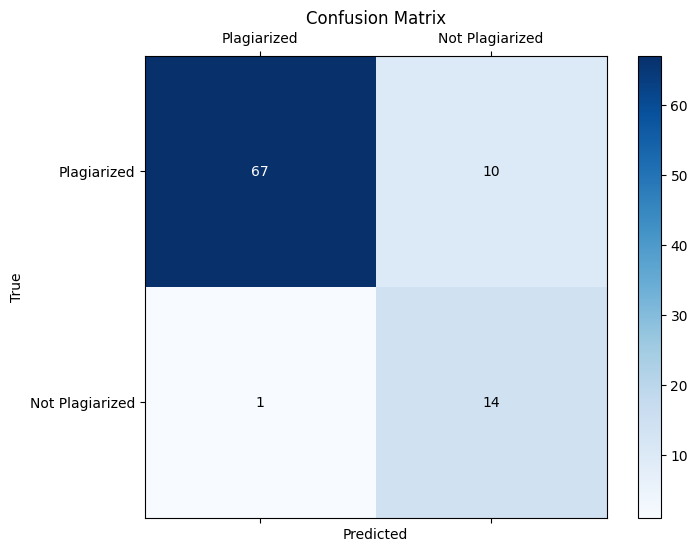

In [267]:
cm = compute_confusion_matrix(loaded_model, test_pairs, device, batch_size=batch_size, threshold=threshold)
plot_confusion_matrix(cm, labels=['Plagiarized', 'Not Plagiarized'])

In [268]:
def plagiarism(path1, path2, model, embedding_layer, node_type_to_idx, parser, device='cpu'):
    def procesar_archivo(filepath):
        with open(filepath, 'r', encoding='utf8') as file:
            code = file.read()
        tree = parser.parse(bytes(code, "utf8"))
        root_node = tree.root_node

        nodes = []
        edges = []
        def traverse(node, parent_idx=None):
            idx = len(nodes)
            nodes.append(node.type)
            if parent_idx is not None:
                edges.append((parent_idx, idx))
            for child in node.children:
                traverse(child, idx)
        traverse(root_node)

        node_features = [node_type_to_idx.get(typ, 0) for typ in nodes]  # manejar tokens fuera de vocabulario
        x = embedding_layer(torch.tensor(node_features)).to(device)
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous().to(device)
        data = Data(x=x, edge_index=edge_index)
        return data

    g1 = procesar_archivo(path1)
    g2 = procesar_archivo(path2)

    g1 = g1.to(device)
    g2 = g2.to(device)

    model.eval()
    with torch.no_grad():
        h1, h2 = model(g1, g2)
        distance = F.pairwise_distance(h1, h2)
        pred = torch.sigmoid(-distance).cpu().item()

    return pred, pred > threshold

plagiarism('./datasets/conplag_preprocessed/a4d6775d.java', './datasets/conplag_preprocessed/cb87df79.java', loaded_model, embedding_layer, node_type_to_idx, parser, device=device)

(0.47585824131965637, True)